# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [1]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Descarga de los datos (URL)
url = 'https://raw.githubusercontent.com/andrab/ecuacovid/master/datos_crudos/ecuacovid.csv'
df = pd.read_csv(url)
df

,muestras,muestras_pcr,muestras_pcr_nuevas,pruebas_rezagadas,muertes_confirmadas,muertes_probables,muertes,muertes_nuevas,positivas,positivas_pcr,...,defunciones_2017,defunciones_2017_nuevas,defunciones_2016,defunciones_2016_nuevas,defunciones_2015,defunciones_2015_nuevas,hospitalizadas_altas,hospitalizadas_estables,hospitalizadas_pronostico_reservadas,created_at
0,129,129,0,106,1,0,1,0,23,23,...,14506,217,13643,212,12866,167,0,0,1,13/03/2020
1,206,206,77,178,2,0,2,1,28,28,...,14718,212,13848,205,13047,181,0,7,3,14/03/2020
2,273,273,67,236,2,0,2,0,37,37,...,14926,208,14048,200,13228,181,0,7,2,15/03/2020
3,354,354,81,296,2,0,2,0,58,58,...,15164,238,14238,190,13388,160,0,9,5,16/03/2020
4,762,762,408,651,2,0,2,0,111,111,...,15347,183,14412,174,13550,162,0,9,5,17/03/2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,569362,548790,2282,51707,8371,4313,12684,14,178150,169194,...,58668,165,56836,183,54618,147,21423,531,342,01/11/2020
234,569798,549226,436,50815,8380,4312,12692,8,178518,169562,...,58844,176,57009,173,54777,159,21476,520,342,02/11/2020
235,570515,549943,717,49712,8386,4312,12698,6,179066,170110,...,59024,180,57218,209,54948,171,21516,512,342,03/11/2020
236,577335,556763,6820,51224,8394,4310,12704,6,180389,171433,...,59237,213,57381,163,55131,183,21552,505,344,04/11/2020


## Datos positivos

In [3]:
df1 = df.loc[:,['created_at','positivas']]
FMT ='%d/%m/%Y'
date = df['created_at']
df1['created_at'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("01/01/2020", FMT)).days)
df1

,created_at,positivas
0,72,23
1,73,28
2,74,37
3,75,58
4,76,111
...,...,...
233,305,178150
234,306,178518
235,307,179066
236,308,180389


## Datos recuperados

In [4]:
df = df.loc[:,['created_at','hospitalizadas_altas']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%d/%m/%Y'
date = df['created_at']
df['created_at'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("01/01/2020", FMT)).days)

df

,created_at,hospitalizadas_altas
0,72,0
1,73,0
2,74,0
3,75,0
4,76,0
...,...,...
233,305,21423
234,306,21476
235,307,21516
236,308,21552


## comparacion de recuperados frente a infectados

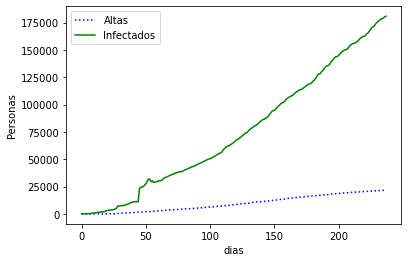

In [5]:
plt.xlabel("dias")   # Inserta el título del eje X
plt.ylabel("Personas")   # Inserta el título del eje Y
plt.plot(df['hospitalizadas_altas'], linestyle=':', color='b', label = "Altas" )  
plt.ion()   # Activa modo interactivo de dibujo
plt.plot(df1['positivas'], linestyle='-', color='g', label = "Infectados")   # Dibuja datos de 
plt.legend(loc="upper left")

## Grafica recuperados

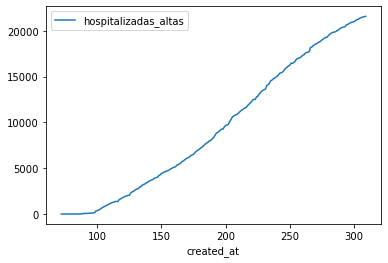

In [6]:
df.plot(x ='created_at', y='hospitalizadas_altas')

## Grafica Infectados

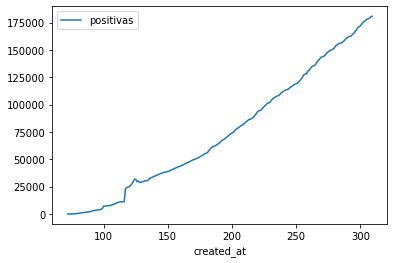

In [8]:
df1.plot(x ='created_at', y='positivas')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo
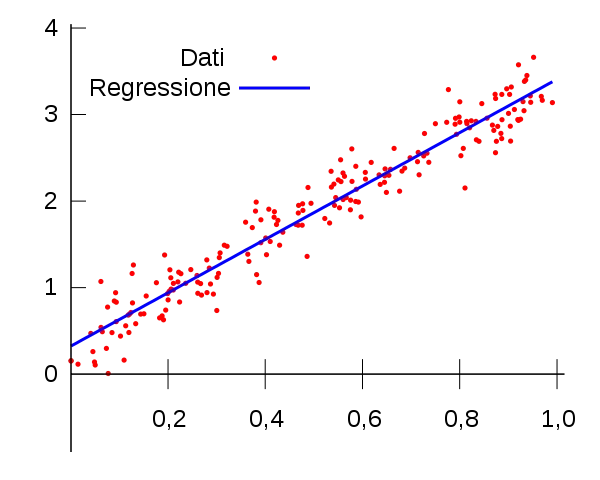
Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.
## Calculo de Error medio y el valor que corta en el eje y 
### Calculo  en el caso de los Recuperados

In [9]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [104.02142343]
Independent term: 
 -10367.177802236833


### Calculo en el caso de los Infectados

In [10]:
x1 = list(df1.iloc [:, 0]) # Fecha
y1 = list(df1.iloc [:, 1]) # Numero de casos
# Creacion el objeto de Regresión Lineal
regr1 = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr1.fit(np.array(x1).reshape(-1, 1) ,y1)

# Muestra los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr1.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr1.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [791.58632372]
Independent term: 
 -75632.48878624591


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»
## Calculo de la prediccion
### Prediccion en el caso de los Recuperados

In [12]:

# Prediccion de cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

34


### Prediccion en el caso de los infectados

In [13]:

# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr1.predict([[100]])
print(int(y_prediccion))

3526


## Grafica de los recuperados

[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285
 286 287 288 289 290 291 292 293 294 295 296 297 298 299]


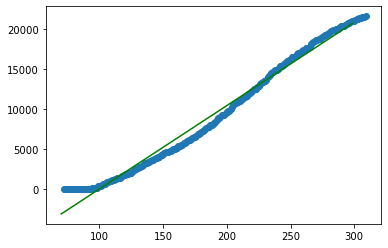

In [14]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(70, 300))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()

## Grafica infectados

[ 90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299]


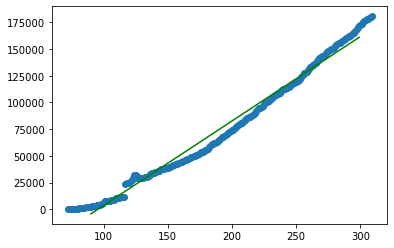

In [16]:
#Graficar
plt.scatter(x1, y1)
x_real1 = np.array(range(90, 300))
print(x_real1)
plt.plot(x_real1, regr1.predict(x_real1.reshape(-1, 1)), color='green')
plt.show()

## Comparacion de las Garaficas y sus predicciones

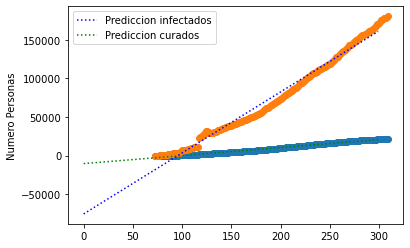

In [19]:
plt.ylabel("Numero Personas")   # Inserta el título del eje Y
plt.scatter(x, y)
x_real1 = np.array(range(0, 300))
plt.plot(x_real1, regr1.predict(x_real1.reshape(-1, 1)), linestyle=':', color='b', label = "Prediccion infectados" )  
plt.ion()   # Activa modo interactivo de dibujo
plt.scatter(x1, y1)
x_real = np.array(range(0, 300))
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), linestyle=':', color='g', label = "Prediccion curados")   # Dibuja datos de  
plt.legend(loc="upper left")

## Analisis
lo que se puede sacar del analisi de los datatos es que existe un  gran desfase entre el numero de infectados y el numero de recuperados
## Conclusiones
segun  este modelo se puede concluir que este modelo no se ajusta alos datos de ingreso locual implica que exista un desface en la prediccion a futuro
## Criterio personal (politico, economico y  social de la situacion)
lo que se puede concluir es que el indice de recuperados es menor al indice de infectados lo cual causa que el numero de infeectados aumente y aga que los hospitales colapse

# Referencias

- https://github.com/andrab/ecuacovid/tree/master/datos_crudos

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/

- https://python-para-impacientes.blogspot.com/2014/08/graficos-en-ipython.html